* **Vicente Knobel (202505144)**
* **Luiz Gustavo Coutinho Xavier (201905959)**

Neste relatório é apresentada a solução de um problema de visão computacional aplicado a indústria de alimentos, como requisitos para a disciplina **INE410121 - Visão Computacional**. O projeto consiste na aplicação de algoritmos clássicos de visão computacional e redes neurais artificiais para solução do problema de contagem de salgadinhos sortidos em caixas mistas. Em nossa melhor solução com o *fine tune* do modelo pré-treinado [RF-DETR](https://github.com/roboflow/rf-detr), foi possível identificar corretamente diversas classes de salgadinhos em fotografias diversas de caixas, obtendo um mAP@50:95 de 90,51% no teste com nosso dataset.

O relatório é organizado da seguinte forma. Na Seção 1 são apresentadas as características do problema e os datasets construídos. Na Seção 2 é apresentada uma primeira iteração para solução do problema utilizando um pipeline de processamento de visão clássica, que é aprimorada em uma segunda iteração na Seção 3. Na Seção 4 é apresentada a solução com redes neurais artificiais. A Seção 5 apresenta os resultados e a Seção 6 conclui o relatório.


# Descrição do problema
O problema escolhido para atividade consiste na identificação de salgadinhos em caixas sortidas, adotando como exemplo encomendas de salgados produzidas por uma padaria local. Apesar de considerar a produção de um comércio específico, o problema estende-se a indústria de alimentos de modo geral, ao permitir a separação de encomendas de forma mais ágil assegurando controle de qualidade, especialmente em períodos de maior demanda de produção. Caixas sortidas são usualmente encomendadas com 4 ou 5 classes de salgados distintos, e possuem um tamanho padrão para conter um máximo de até 100 salgados. Para o escopo de problema definido neste trabalho, considera-se a existência das seguintes classes:

* Croquete de carne
* Coxinha de frango
* Empada folhada
* Sanduíche colorido
* Sanduíche aberto (canapé de salame com palito acima)
* Canudinho

É importante destacar a similaridade entre classes de salgadinhos no que diz respeito a sua cor e formato, o que representa um maior desafio na resolução do problema. Croquetes de carne apesar de majoritariamente marrons, possuem pigmentos pastéis da mesma cor das coxinhas devido a farinha utilizada em sua fabricação. Coxinhas e empadas também possuem grande similaridade de formato e cor.

As imagens do dataset não artificial, utilizado nas solução com visão clássica, se encontram disponíveis no diretório **/dataset**, totalizando 21 imagens. Diversas combinações de organizações com as seis classes de salgadinhos foram exploradas, incluindo organizações mais simples com somente uma classe. As imagens foram capturadas em alta resolução ($4032 \times 3024$) por uma câmera de celular.

As imagens do dataset artificial se encontram disponíveis no diretório **dataset_sinth_labeled_yolo_raw/**, que não foi adicionado ao repositório por limitação de tamanho, mas se encontram disponíveis em anexo.

# Abordagem 1: segmentação simples
Como primeira solução, foi implementado um pipeline simples de processamento de imagem utilizando algoritmos clássicos de visão computacional com o objetivo de identificar uma classe de salgadinhos por vez. Cada uma das etapas é descrita como segue, seguido de sua respectiva implementação.

## Inicialização e Carregamento de Imagem

Nesta primeira etapa são somente definidas algumas funções auxiliares para o carregamento e visualização de imagens. A função `load_image()` realiza a leitura de arquivos de imagem utilizando a biblioteca OpenCV e efetua a conversão do espaço de cores de BGR para RGB. A imagem original é armazenada nas variáveis globais `ORIGINAL_IMG` e `PIPELINE_IMG`, servindo como ponto de referência inicial para todas as operações subsequentes do pipeline de processamento. A função `show_2_images()` facilita a comparação lado a lado de duas imagens processadas, utiliza subplots do Matplotlib.

In [1]:
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import cv2
import numpy as np


def load_image(source):
    try:
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    except Exception as e:
        print(f"could not load image, err: {e}")
        return None


def show_2_images(image1, image2, title1, title2):
    _, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title(title1)

    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title(title2)

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'
ORIGINAL_IMG = load_image(IMAGE_PATH)
PIPELINE_IMG = ORIGINAL_IMG

## Segmentação por Cor no Espaço HSV

A segmentação por cor constitui a etapa inicial de isolamento de regiões de interesse no pipeline. Esta implementação converte a imagem para o espaço de cor HSV, mais apropriado para segmentação baseada em tonalidade em comparação ao espaço RGB, e aplica operações de thresholding binárias definidas por limites inferiores e superiores de cada canal.

O método `cv2.inRange()` efetua o thresholding bidirecional, produzindo uma máscara binária onde pixels dentro do intervalo especificado recebem valor 255 (branco) e fora do intervalo recebem 0 (preto). Diversas combinações foram avaliadas, entretanto os valores aqui apresentados foram empiricamente calibrados para isolar os salgadinhos da classe **croquete**, correspondendo a tonalidades na faixa de marrom definida pelos valores `[8, 130, 10]` a `[24, 180, 140]`.

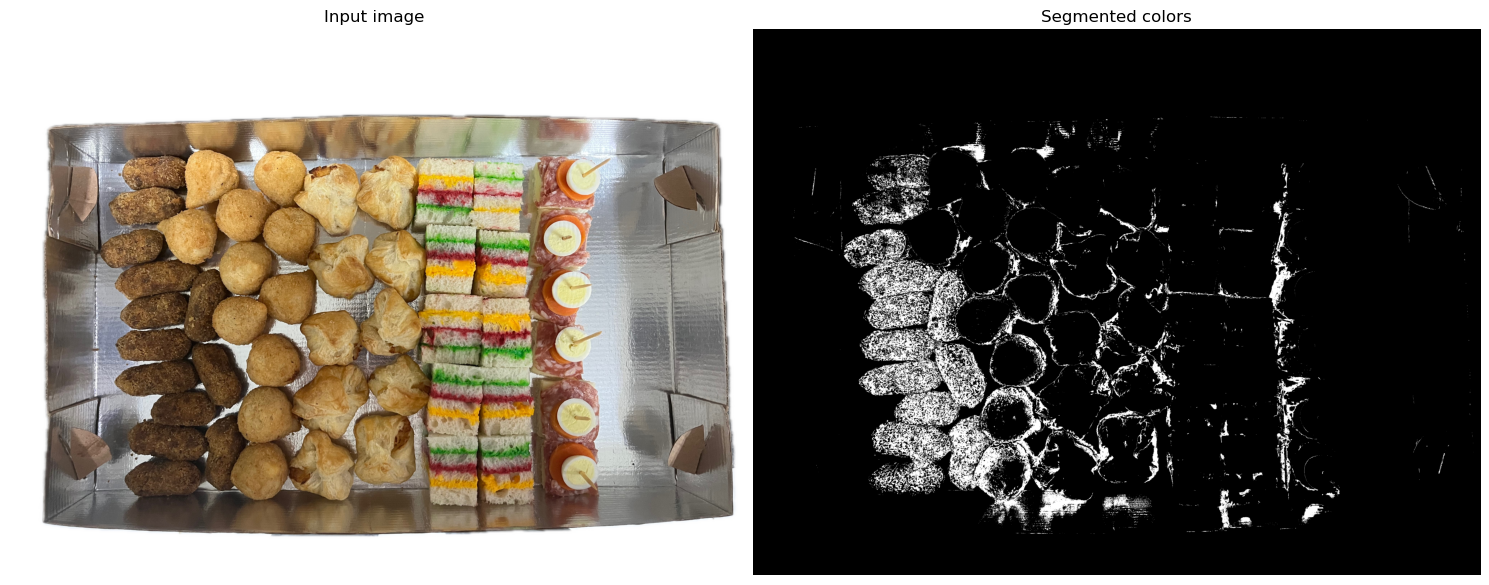

In [2]:
def segment_by_color(image, lower_threshold, upper_threshold):
    global PIPELINE_IMG
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    PIPELINE_IMG = cv2.inRange(hsv_image, lower_threshold, upper_threshold)
    show_2_images(image, PIPELINE_IMG, 'Input image', 'Segmented colors')


lower_t = np.array([8, 130, 10])
upper_t = np.array([24, 180, 140])

segment_by_color(PIPELINE_IMG, lower_t, upper_t)

## Operações Morfológicas de Fechamento

A operação de fechamento (closing) é uma técnica de processamento morfológico que combina dilatação seguida de erosão, com o objetivo de preencher pequenas cavidades e remoção de ruído na máscara binária resultante da segmentação. Especificamente, a dilatação expande regiões brancas, preenchendo gaps internos, enquanto a erosão subsequente restaura a imagem ao tamanho original. O kernel estruturante define a vizinhança considerada na operação; neste caso, utiliza-se um kernel retangular $7 \times 7$.

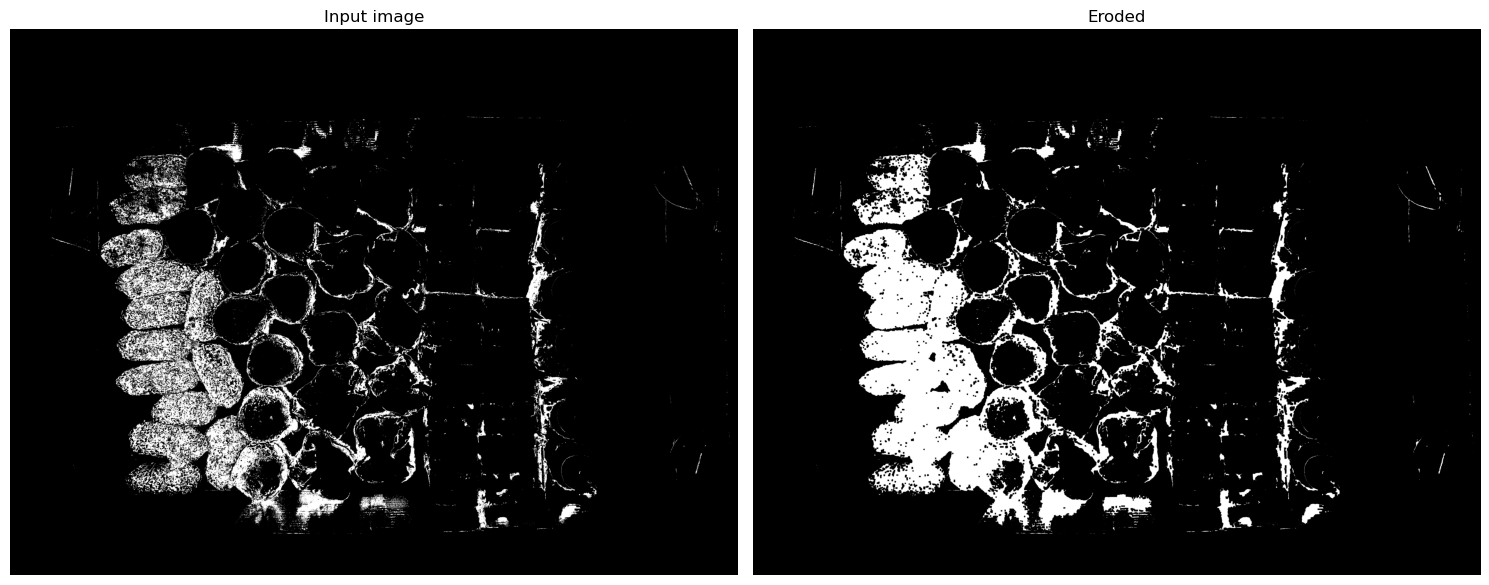

In [3]:
def apply_closing(image, kernel_size, iterations):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    PIPELINE_IMG = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Eroded')


apply_closing(image=PIPELINE_IMG, kernel_size=(7,7), iterations=1)

## Detecção de Bordas via Algoritmo de Canny

Em sequência é realizada a detecção de bordas utilizando o algoritmo de Canny. Este método aplica inicialmente um filtro bilateral `cv2.bilateralFilter()` para suavização seletiva com preservação de bordas, reduzindo ruído. O resultado é um mapa binário de bordas, em que apenas pixels que representam mudanças significativas de intensidade são ativados.

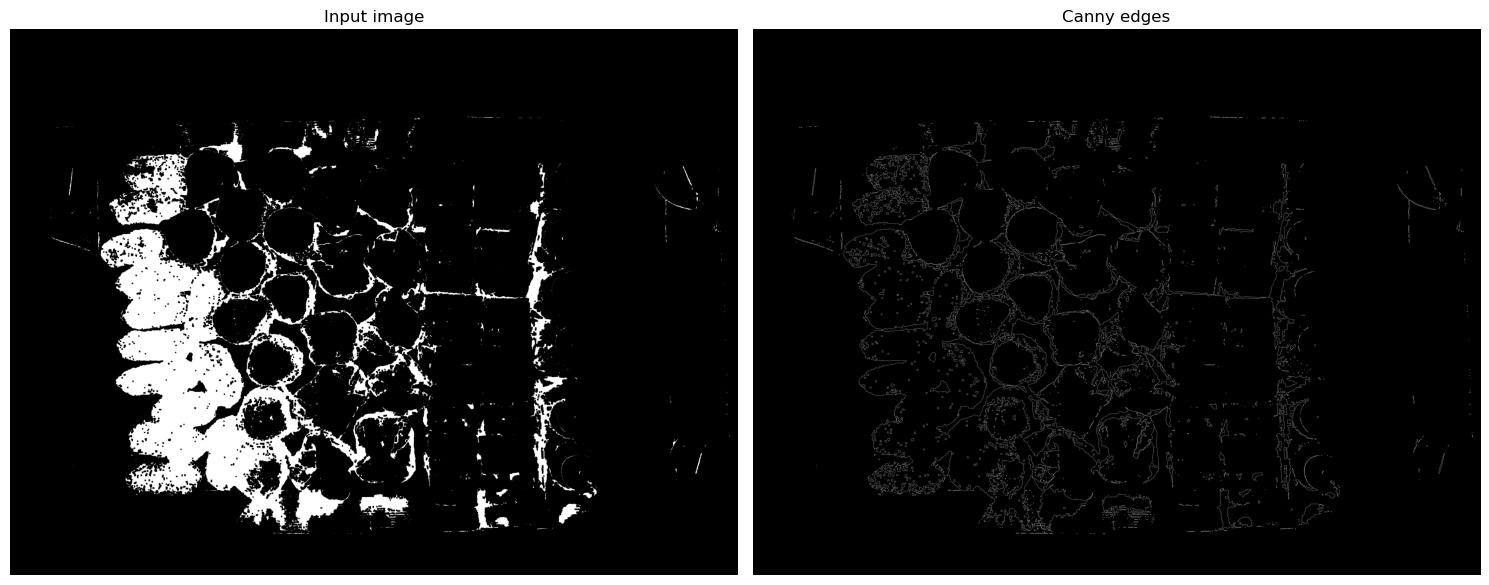

In [4]:
def apply_canny(image, threshold1, threshold2, apertureSize, L2gradient):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blurred_image = cv2.bilateralFilter(gray_image, 50, 90, 90)

    PIPELINE_IMG = cv2.Canny(blurred_image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient) 
    show_2_images(image, PIPELINE_IMG, 'Input image', 'Canny edges')


# NOTE: Original image best with gaussian blurred at 65/195 or bilaterealFilter at 15/45
#apply_canny(image=ORIGINAL_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

apply_canny(image=PIPELINE_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

## Detecção e Contagem de Elipses

A identificação de elipses consiste na detecção de contornos na imagem binária, onde para cada contorno com número suficiente de pontos, ajusta-se uma elipse utilizando `cv2.fitEllipse()`. Os candidatos são então filtrados mediante critérios geométricos, como: (i) área mínima, (ii) razão entre área do contorno e área da elipse ajustada, e (iii) razão entre semieixos da elipse, rejeitando formas muito alongadas ou muito pequenas.

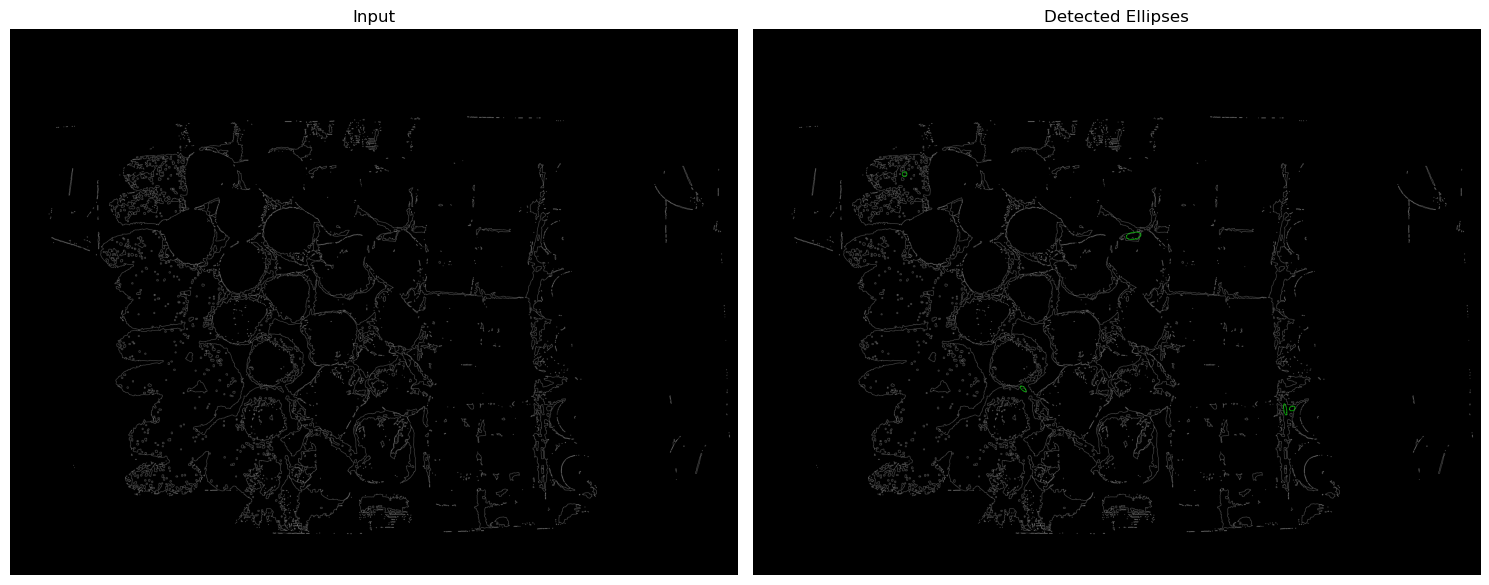

detected: 5


In [5]:
def count_ellipses_contours(image, area_min=500, area_ratio_tol=0.9, axis_ratio_max=5.0):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    _, th = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #mask = np.zeros_like(image)
    
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_min or len(cnt) < 5:
            continue
        
        ellipse = cv2.fitEllipse(cnt)
        (MA, ma) = ellipse[1]
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        ellipse_area = np.pi * a * b
        if ellipse_area <= 0:
            continue
        
        area_ratio = area / ellipse_area
        axis_ratio = (MA / ma) if ma > 0 else 999
        
        if area_ratio >= area_ratio_tol and axis_ratio <= axis_ratio_max:
            cv2.ellipse(out, ellipse, (0,255,0), 2)
            #cv2.drawContours(mask, [cnt], -1, 255, -1)
            count += 1

    return count, out


count, out = count_ellipses_contours(PIPELINE_IMG)
show_2_images(PIPELINE_IMG, out, 'Input', 'Detected Ellipses')

print('detected:', count)

# Abordagem 2: Segmentação por distância de Mahalanobis

A segmentação por distância de Mahalanobis constitui uma abordagem mais sofisticada para isolamento de regiões de interesse no pipeline, considerando a covariância dos dados para uma segmentação mais precisa. Este método converte a imagem para o espaço de cor HSV e calcula a distância de Mahalanobis de cada pixel em relação a uma cor alvo, levando em conta a distribuição estatística das cores presentes na imagem.

A distância de Mahalanobis é uma métrica que normaliza a distância considerando a correlação entre as dimensões do espaço de cor, sendo particularmente eficaz para segmentação quando há variação na distribuição de cores. O algoritmo inicia coletando uma amostra de pixels próximos à cor alvo dentro de um intervalo empírico, calcula a matriz de covariância desta amostra, e em seguida computa a distância de Mahalanobis de todos os pixels em relação à média das amostras. Pixels com distância inferior ao limiar especificado formam a máscara de segmentação.

As demais etapas do pipeline são as mesmas que apresentadas no notebook anterior, e devido a isso, não foram includas suas descrições e suas funções são importadas diretamente no bloco de código implementado a seguir.

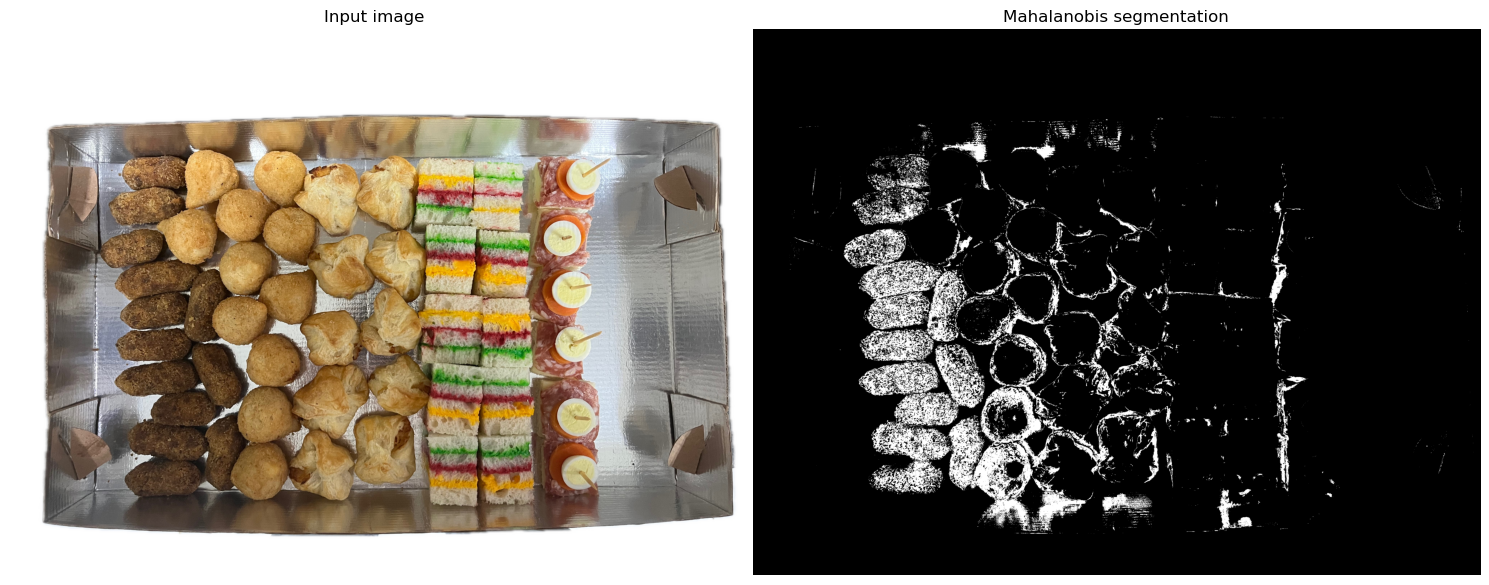

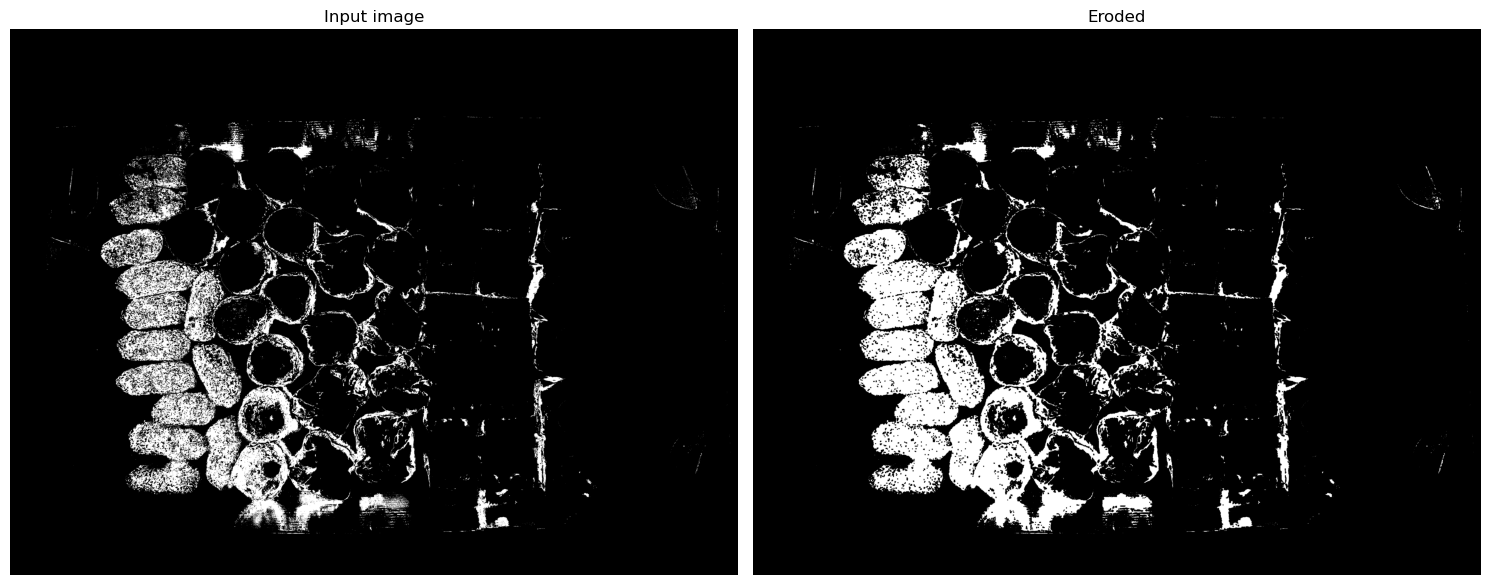

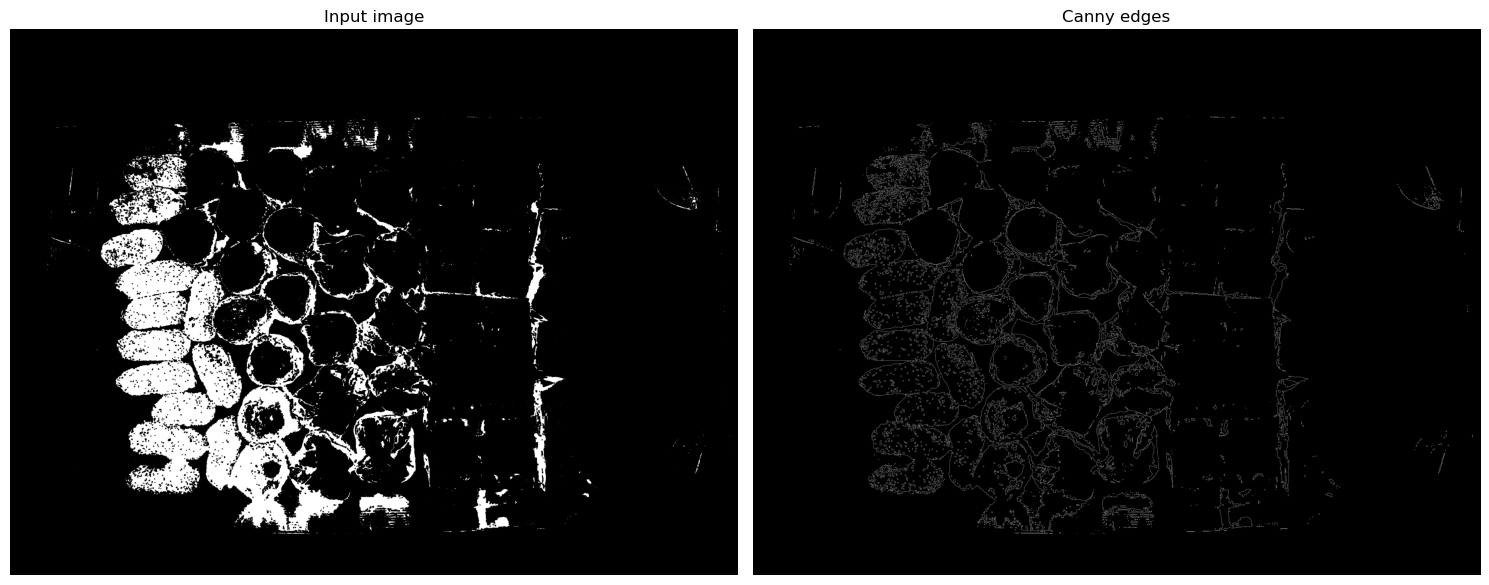

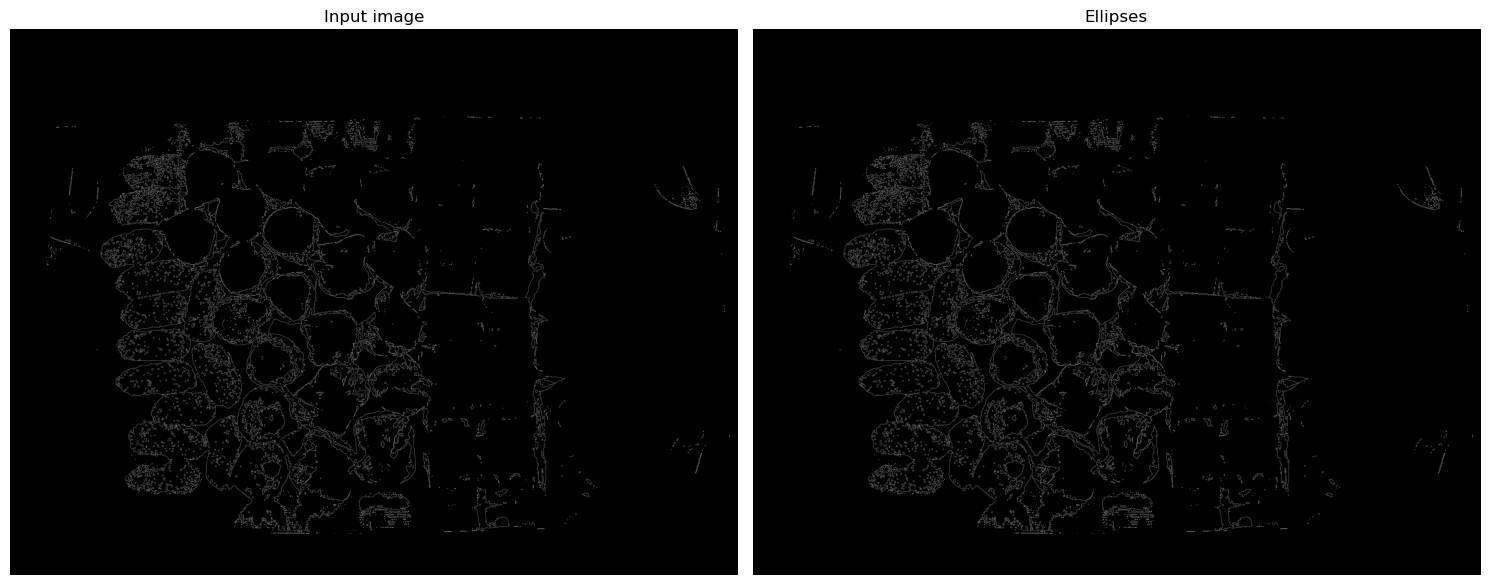

detected: 0


In [ ]:
from scipy.spatial.distance import mahalanobis


IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'
ORIGINAL_IMG = load_image(IMAGE_PATH)
PIPELINE_IMG = ORIGINAL_IMG


def segment_by_mahalanobis(image, target_color, lower_bound, upper_bound, threshold=10.0):
    global PIPELINE_IMG

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Reshape HSV image to (N, 3) for processing
    h, w = hsv_image.shape[:2]
    hsv_flat = hsv_image.reshape(-1, 3).astype(np.float32)

    mask_sample = cv2.inRange(hsv_image, lower_bound, upper_bound)
    sample_pixels = hsv_flat[mask_sample.flatten() > 0]
    
    if len(sample_pixels) < 3:
        # If no samples found, use a default covariance
        cov_matrix = np.eye(3) * 100
        mean_color = target_color.astype(np.float32)
    else:
        mean_color = np.mean(sample_pixels, axis=0)
        cov_matrix = np.cov(sample_pixels.T)
        
        # Ensure covariance matrix is invertible
        if np.linalg.matrix_rank(cov_matrix) < 3:
            cov_matrix += np.eye(3) * 0.1
    
    # Calculate inverse covariance matrix for mahalanobis function
    try:
        inv_cov = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov_matrix)
    
    # Calculate Mahalanobis distance for all pixels using scipy function
    distances = np.array([mahalanobis(pixel, mean_color, inv_cov) for pixel in hsv_flat])
    
    # Create binary mask based on threshold
    PIPELINE_IMG = (distances < threshold).astype(np.uint8).reshape(h, w) * 255
    #PIPELINE_IMG = (distances).astype(np.uint8).reshape(h, w)
    
    show_2_images(image, PIPELINE_IMG, 'Input image', 'Mahalanobis segmentation')
    
    return PIPELINE_IMG


# NOTE:
# brown colors HSV:
# [8, 130, 10]
# [10, 56, 127]
# [14, 140, 40]
# [15, 134, 135] -> identifies all with 8 threshold and 20 sample
# [10, 100, 80]  -> mid-brown
# [12, 110, 100] -> slightly lighter
# [8, 120, 90]   -> darker brown
#
# orange colors HSV:
# [17, 142, 190]

target_brown_color = np.array([8, 130, 10])

# interval range are the same from previous color segmentation
lower_bound = np.array([8, 130, 10])
upper_bound = np.array([24, 180, 140])

segment_by_mahalanobis(ORIGINAL_IMG, target_brown_color, lower_bound, upper_bound, threshold=2.3)


apply_closing(image=PIPELINE_IMG, kernel_size=(5,5), iterations=1)
apply_canny(image=PIPELINE_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

count, out = count_ellipses_contours(PIPELINE_IMG)
show_2_images(PIPELINE_IMG, out, 'Input image', 'Ellipses')
print('detected:', count)

# Abordagem 3: Classificação e contagem de salgadinhos com Deep Learning

Nesta seção é apresentada a solução do problema utilizando aprendizado profundo. O processo de geração do modelo se deu por uma sequencia de passos organizados nas seções que seguem:

1. Busca manual de imagens exemplo no google imagens
2. Geração de [*novel view synthesis*](https://en.wikipedia.org/wiki/View_synthesis) das imagens adquiridas usando o modelo [Nano Banana Pro](https://blog.google/technology/ai/nano-banana-pro/) da Google.
3. *Labeling* bruto usando [sam3](https://github.com/facebookresearch/sam3)
4. Refinamento das labels usando [Label Studio](https://labelstud.io/)
5. Treinamento usando modelos [RF-DETR](https://github.com/roboflow/rf-detr) 

## Geração do *dataset*

### Busca manual pelo google imagens
Começamos o processo definindo quais salgadinhos o modelo deve indentificar. Buscamos representar os salgadinhos mais comuns vendidos por empresas de alimentos para festas, chegando na lista:
- Bolinha de queijo
- Canapé
- Canudo
- Coxinha
- Croquete
- Empadinha
- Enroladinho de salsicha
- Esfiha
- Folhado
- Pastelzinho
- Pão de queijo
- Quibe
- Risoles
- Sanduiche

Buscamos 30 imagens de cada classe, além de um conjunto de imagens de bandejas cheias, denominado 'grupo'. A Heuristica de inclusão priorizava a escolha de imagens por:
- Conter multiplos exemplares do salgadinho buscado em uma unica foto
- Salgadinhos fotografados no angulo *top-down*
- Salgadinhos em bandejas são preferenciais a salgadinhos em potes ou empilhados

![imagens de coxinhas selecionadas](relatorio2Images/coxinhas_google.jpg)
Acima: Imagens de coxinhas selecionadas

## Novel view synthesis com Nano Banana Pro
No processo de buscar exemplos no google, nos deparamos com um forte viés em fotos de uma perspectiva lateral ao corpo de salgados, coerente com propagandas e divulgação. Embora seja relevante que nosso modelo trabalhe com este outro angulo de visão, achamos preocupante a ausência de fotos de vista superior.

A vista superior é a perspectiva que estipulamos como nosso caso de uso principal com o modelo sendo colocado em produção por padeiros interessados em contar os salgados em suas caixas antes de despachar para entrega.

Para gerar essas vistas fizemos uso do novo modelo de geração, edição e manipulação de imagens da Google, o [Nano Banana Pro](https://blog.google/technology/ai/nano-banana-pro/).

O modelo está disponivel pelo [serviço de API dos modelos Gemini](https://ai.google.dev/gemini-api/docs/image-generation) e por meio de *prompt engineering*, implementamos uma geração que extrapola quatro novas imagens a partir da imagem original, em uma unica geração.

- Uma geração de vista lateral, similar a imagem original;
- Uma geração top-down, dos salgadinhos no chão - mudando o fundo dos salgadinhos e variando o fundo;
- Uma geração top-down, com luz noturna, diversificando condições de iluminação
- Uma geração top-down dos salgados na sua disposição original.

![imagens de coxinhas geradas pelo modelo Nano Banana](relatorio2Images/nanoBanana.jpg)
Acima: Imagens de coxinhas geradas pelo modelo Nano Banana

#### Novel View Synthesis: código

##### bibliotecas

In [ ]:
!pip install -U google-genai #api para acesso aos modelos de IA da Google
!pip install -U pillow #bibilioteca de manipulação de imagens
!pip install -U opencv-python #bibilioteca de visão computacional
!pip install -U tqdm #progress bar

##### imports e definições

In [ ]:
api_key='' #your google api key here

from google import genai
from google.genai import types
from PIL import Image

import os
from pathlib import Path
from PIL import Image

from tqdm import tqdm

import cv2
import numpy as np
import glob
import math
from pathlib import Path

##### funções

In [ ]:
def nanoBananaGeneration(client, prompt, image_path_in, image_path_out):
    # Define a proporção de aspecto da imagem gerada
    aspect_ratio = "5:4" # "1:1","2:3","3:2","3:4","4:3","4:5","5:4","9:16","16:9","21:9"
    # Define a resolução da imagem gerada
    resolution = "1K" # "1K", "2K", "4K"
    
    # Faz uma chamada ao modelo Gemini para gerar conteúdo (texto e imagem)
    response = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        # Passa o prompt de texto e a imagem de entrada como conteúdo
        contents=[
            prompt,
            Image.open(image_path_in),
        ],
        # Configura os parâmetros de geração
        config=types.GenerateContentConfig(
            # Define que a resposta pode conter texto e imagem
            response_modalities=['TEXT', 'IMAGE'],
            # Configura as propriedades da imagem a ser gerada
            image_config=types.ImageConfig(
                aspect_ratio=aspect_ratio,
                image_size=resolution
            ),
        )
    )
    
    # Itera sobre as partes da resposta gerada
    for part in response.parts:
        # Se a parte contém texto, imprime no console
        if part.text is not None:
            print(part.text)
        # Se a parte contém uma imagem, salva no caminho de saída
        elif image:= part.as_image():
            image.save(image_path_out)

def collect_image_paths(input_folder):
    # Define as extensões de arquivo de imagem aceitas
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    # Inicializa lista vazia para armazenar os caminhos
    paths = []
    # Percorre recursivamente todos os arquivos e subpastas da pasta de entrada
    for root, _, files in os.walk(input_folder):
        # Para cada arquivo encontrado
        for f in files:
            # Verifica se a extensão do arquivo está na lista de extensões aceitas (ignorando maiúsculas/minúsculas)
            if Path(f).suffix.lower() in exts:
                # Adiciona o caminho completo do arquivo à lista
                paths.append(Path(root) / f)
    # Retorna a lista de caminhos das imagens encontradas
    return paths

def filter_unprocessed(paths, input_folder, output_folder):
    # Converte as pastas de entrada e saída para objetos Path
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    # Inicializa lista para armazenar apenas os caminhos não processados
    filtered = []
    # Para cada caminho de imagem de origem
    for src_path in paths:
        # Obtém o caminho relativo da imagem em relação à pasta de entrada
        rel = src_path.relative_to(input_folder)
        # Remove a extensão do caminho relativo
        rel_no_ext = rel.with_suffix("")
        # Constrói o caminho de destino na pasta de saída com extensão .jpg
        dst_path = (output_folder / rel_no_ext).with_suffix(".jpg")
        # Se o arquivo de destino não existe, adiciona à lista de não processados
        if not dst_path.exists():
            filtered.append(src_path)
    # Retorna apenas os caminhos que ainda não foram processados
    return filtered

def process_paths(paths, input_folder, output_folder, client, prompt):
    # Converte as pastas de entrada e saída para objetos Path
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    
    # Garante que a pasta de saída raiz existe (cria se não existir)
    output_folder.mkdir(parents=True, exist_ok=True)
    # Itera sobre os caminhos com barra de progresso usando tqdm
    for src_path in tqdm(paths, desc="Processing images"):
        # Obtém o caminho relativo da imagem em relação à pasta de entrada
        rel_path = src_path.relative_to(input_folder)
        # Remove a extensão do caminho relativo
        rel_no_ext = rel_path.with_suffix("")
        # Constrói o caminho de destino na pasta de saída com extensão .jpg
        dst_path = (output_folder / rel_no_ext).with_suffix(".jpg")
        # Garante que as subpastas necessárias existem no destino
        dst_path.parent.mkdir(parents=True, exist_ok=True)
        # Tenta processar a imagem
        try:
            # Abre a imagem de origem e converte para RGB
            img = Image.open(src_path).convert("RGB")
            # Chama a função de geração com o cliente, prompt e caminhos
            nanoBananaGeneration(client, prompt, src_path, dst_path)
        # Se houver qualquer erro, ignora e continua para a próxima imagem
        except:
            continue

def resize_to_box(img, box_w=1440, box_h=720):
    # Obtém a altura e largura da imagem
    h, w = img.shape[:2]
    # Calcula o fator de escala para caber na caixa, mantendo proporção (usa o menor dos dois)
    scale = min(box_w / w, box_h / h)
    # Calcula a nova largura aplicando o fator de escala
    new_w = int(w * scale)
    # Calcula a nova altura aplicando o fator de escala
    new_h = int(h * scale)
    # Redimensiona a imagem com interpolação INTER_AREA (boa para redução)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

def create_collage(input_folder, out_path="collage.jpg", box_w=1440, box_h=720):
    # Converte a pasta de entrada para objeto Path
    input_folder = Path(input_folder)
    # Obtém lista ordenada de todos os caminhos de arquivos na pasta
    image_paths = sorted(glob.glob(str(input_folder / "*")))
    # Inicializa lista vazia para armazenar as imagens carregadas
    images = []
    # Para cada caminho de imagem
    for p in image_paths:
        # Tenta carregar a imagem usando OpenCV
        img = cv2.imread(p)
        # Se a imagem não pôde ser carregada, pula para a próxima
        if img is None:
            continue
        # Redimensiona a imagem para caber na caixa definida
        img = resize_to_box(img, box_w, box_h)
        # Adiciona a imagem redimensionada à lista
        images.append(img)
    # Se nenhuma imagem foi carregada, imprime mensagem e sai
    if not images:
        print("No images found.")
        return
    # --- constrói grade automaticamente ---
    # Conta o número total de imagens
    n = len(images)
    # Calcula o número de colunas (arredonda para cima a raiz quadrada)
    cols = math.ceil(math.sqrt(n))
    # Calcula o número de linhas necessárias
    rows = math.ceil(n / cols)
    # Define largura e altura de cada célula da grade
    cell_w, cell_h = box_w, box_h
    # Calcula largura total da colagem
    collage_w = cols * cell_w
    # Calcula altura total da colagem
    collage_h = rows * cell_h
    # Cria um array numpy vazio (preto) para a colagem completa
    collage = np.zeros((collage_h, collage_w, 3), dtype=np.uint8)
    # Inicializa índice da imagem atual
    i = 0
    # Para cada linha da grade
    for r in range(rows):
        # Para cada coluna da grade
        for c in range(cols):
            # Se já processou todas as imagens, interrompe
            if i >= n: break
            # Pega a imagem atual
            img = images[i]
            # Calcula o deslocamento vertical para centralizar a imagem na célula
            y_offset = r * cell_h + (cell_h - img.shape[0]) // 2
            # Calcula o deslocamento horizontal para centralizar a imagem na célula
            x_offset = c * cell_w + (cell_w - img.shape[1]) // 2
            # Coloca a imagem na posição calculada dentro da colagem
            collage[y_offset:y_offset+img.shape[0],
                    x_offset:x_offset+img.shape[1]] = img
            # Avança para a próxima imagem
            i += 1

    # Redimensiona a colagem para ter o tamanho final da caixa de interesse
    collage = resize_to_box(collage, box_w, box_h)
    # Salva a colagem final no caminho especificado
    cv2.imwrite(out_path, collage)
    # Imprime mensagem confirmando o salvamento
    print("Saved:", out_path)

def slice_images_into_four(input_folder, output_folder="imagens_cortadas"):
    # Converte as pastas de entrada e saída para objetos Path
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    
    # Define as extensões de arquivo de imagem aceitas
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    
    # Garante que a pasta de saída raiz existe (cria se não existir)
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Coleta todos os caminhos de imagens recursivamente
    image_paths = []
    for root, _, files in os.walk(input_folder):
        for f in files:
            if Path(f).suffix.lower() in exts:
                image_paths.append(Path(root) / f)
    
    # Itera sobre os caminhos com barra de progresso usando tqdm
    for src_path in tqdm(image_paths, desc="Slicing images"):
        # Tenta processar a imagem
        try:
            # Carrega a imagem usando OpenCV
            img = cv2.imread(str(src_path))
            # Se a imagem não pôde ser carregada, pula para a próxima
            if img is None:
                continue
            
            # Obtém a altura e largura da imagem
            h, w = img.shape[:2]
            # Calcula a altura de cada fatia (metade da altura total)
            half_h = h // 2
            # Calcula a largura de cada fatia (metade da largura total)
            half_w = w // 2
            
            # Define as 4 fatias da imagem (superior esquerda, superior direita, inferior esquerda, inferior direita)
            slices = [
                img[0:half_h, 0:half_w],           # fatia 0: superior esquerda
                img[0:half_h, half_w:w],           # fatia 1: superior direita
                img[half_h:h, 0:half_w],           # fatia 2: inferior esquerda
                img[half_h:h, half_w:w]            # fatia 3: inferior direita
            ]
            
            # Obtém o caminho relativo da imagem em relação à pasta de entrada
            rel_path = src_path.relative_to(input_folder)
            # Obtém o caminho relativo sem a extensão
            rel_no_ext = rel_path.with_suffix("")
            
            # Para cada fatia (0 a 3)
            for idx, slice_img in enumerate(slices):
                # Constrói o caminho de destino adicionando o índice da fatia ao nome
                dst_path = (output_folder / f"{rel_no_ext}_{idx}").with_suffix(".jpg")
                # Garante que as subpastas necessárias existem no destino
                dst_path.parent.mkdir(parents=True, exist_ok=True)
                # Salva a fatia da imagem
                cv2.imwrite(str(dst_path), slice_img)
        
        # Se houver qualquer erro, ignora e continua para a próxima imagem
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
            continue
    
    # Imprime mensagem de conclusão
    print(f"Slicing complete! Images saved to: {output_folder}")



##### execução
Folder com as imagens baixadas deve estar na estrutura
```
dataset/
├── coxinha/
│   ├── coxinha0001.jpg
│   ├── coxinha0002.jpg
│   ├── coxinha0003.jpg
│   └── ...
├── bolinha_de_queijo/
│   ├── bolinha0001.jpg
│   ├── bolinha0002.jpg
│   └── ...
└── pastel/
    ├── pastel0001.jpg
    ├── pastel0002.jpg
    └── ...
```


In [ ]:
input_folder = "dataset"
output_folder = "dataset_sinth"

#coleta paths de todas as imagens
paths = collect_image_paths(input_folder) 

#remove da lista imagens do qual as vistas sintéticas já foram criadas
paths = filter_unprocessed(paths, input_folder, output_folder)

In [ ]:
#imprime os paths das imagens baixadas do google
paths

In [ ]:
# o cliente recebe a chave da API declarada acima
client = genai.Client(api_key=api_key)

#o prompt detalha as visadas da imagem apresentada que nos interessam.
prompt = ("""
Hi! I'm doing a image training dataset of Brazilian Salgadinhos, and want to generate novel views of the image i sent you. Follow the generation guide below please!
 {

  "style_mode": "raw_photoreal_documentary_collage",

  "look": "casual product photography, domestic setting, natural and ambient lighting, 2x2 grid layout",

  "layout_structure": {

    "format": "four-panel collage (2x2 grid)",

    "description": "The image is divided into four distinct rectangular quadrants, each presenting a different angle and lighting condition of the subject on the source image."

  },

  "camera": {

    "vantage": "variable per quadrant (high-angle, eye-level, low-angle, top-down)",

    "framing": "medium to close-up shots",

    "lens_behavior": "smartphone camera aesthetic, varying depth of field (shallow in macro shots, deep in environmental shots)",

    "sensor_quality": "standard digital photography, slight ISO noise in darker areas, realistic sharpness"

  },

  "scene": {

    "quadrant_details": {

      "top_left": {

        "perspective": "high-angle three-quarter view",

        "lighting": "same as the source image",

        "background": "same as the source image",

      },

      "top_right": {

        "perspective": "direct top-down (flat lay)",

        "lighting": "same as the source image",

        "background": "Salgadinhos on the image out of the tray and on the floor",


      },

      "bottom_left": {

        "perspective": "direct top-down (flat lay)",

        "lighting": "nightime lighting",

        "background": "same as the source image",

      },

      "bottom_right": {

        "perspective": "direct top-down (flat lay)",

        "lighting": "same as the source image",

        "background": "same as the source image",


      }

    }

  },

  "aesthetic_controls": {

    "render_intent": "view expansion of source image",

    "material_fidelity": [

    "same as source, upscale as needed."
    
    ],

    "color_grade": {

      "overall": "same as source)",


    }

  },

  "negative_prompt": {

    "forbidden_elements": [

      "people",

      "animals (living)",

      "bright neon colors",

      "text overlays",

      "studio backdrop",

      "vector graphics",

      "cartoon style"

    ]

  }

} 
""")

#processamos as imagens baixadas, gerando novas vistas e augumentando o dataset
process_paths(paths, input_folder, output_folder, client, prompt)

In [ ]:
#visualização das imagens geradas, salva como collage.jpg no diretório atual do notebook
create_collage("dataset_sinth/coxinha")

In [ ]:
#recortamos as imagens geradas em 4, salvando cada corte individualmente
slice_images_into_four('dataset_sinth','dataset_sinth_cut')

## *Labeling* bruto com sam3

Para treinar modelos de detecção de objetos capazes de identificar, classificar e contar elementos em imagens, é fundamental estruturar adequadamente o dataset de treinamento. 

Cada imagem precisa estar acompanhada de anotações que especifiquem a localização e categoria dos objetos presentes, sendo essas informações armazenadas em arquivos de labels. Existem diversos formatos consolidados na comunidade de visão computacional: 

- o **formato YOLO** utiliza arquivos `.txt` individuais para cada imagem, com coordenadas normalizadas no padrão `<classe> <x_centro> <y_centro> <largura> <altura>` (valores entre 0 e 1);
- o **formato COCO** (Common Objects in Context) emprega um único arquivo JSON centralizado contendo todas as anotações do dataset, com coordenadas absolutas em pixels no formato `[x_min, y_min, largura, altura]` e suporte nativo para segmentação e keypoints;
- o **formato Pascal VOC** (Visual Object Classes) usa arquivos XML individuais por imagem, armazenando bounding boxes como `<xmin>, <ymin>, <xmax>, <ymax>` em pixels absolutos.

A escolha entre esses formatos frequentemente depende das ferramentas de anotação disponíveis e do framework de treinamento, embora conversões entre formatos sejam relativamente simples. Independentemente do formato escolhido, a qualidade e consistência das anotações são fatores determinantes para o desempenho do modelo em tarefas de detecção e contagem de objetos.

Do [README do modelo](https://github.com/facebookresearch/sam3/blob/main/README.md):
> SAM 3 is a unified foundation model for promptable segmentation in images and videos. It can detect, segment, and track objects using text or visual prompts such as points, boxes, and masks. Compared to its predecessor SAM 2, SAM 3 introduces the ability to exhaustively segment all instances of an open-vocabulary concept specified by a short text phrase or exemplars.

Usamos o modelo sam3 para, com um prompt simples como 'food', 'snacks' ou 'croquette', segmentar e gerar bounding boxes para os salgadinhos presentes em uma batelada de imagens, separadas por classe. Salvamos esses resultados com .txts no formato YOLO. O conjunto de fotos de 'grupo' é salvo com a classe 'coxinha'. No proximo passo usaremos a ferramenta 'label studio' para consertar labelings equivocados.

![bounding boxes geradas por sam3](relatorio2Images/sam3_raw_bbox.png)
Acima: Bounding boxes geradas por sam3

#### *Labeling* bruto com sam3: código

##### bibiliotecas e instalações

In [ ]:
!pip install -U torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
#baixando e instalando sam3 a partir do github

import os
from pathlib import Path

# save current dir
start_dir = Path.cwd()

# clone
!git clone https://github.com/facebookresearch/sam3.git

# go into repo
os.chdir("sam3")

# install things
!pip install -e .
!pip install -e ".[notebooks]"

# return to original notebook dir
os.chdir(start_dir)

print("Now back in:", Path.cwd())


##### imports e definições

In [ ]:
import os

import numpy as np

import sam3
from PIL import Image

import sys

#utils sam3
from huggingface_hub import login
from sam3.sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import normalize_bbox
import torch

#para mostrar as bounding boxes
import glob
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown


##### funções

In [ ]:
def strip_ext(path):
    # Remove a extensão do arquivo do caminho fornecido
    # Ex: "imagem.jpg" -> "imagem"
    return os.path.splitext(path)[0]

def convert_to_yolo(bbox, img_width, img_height):
    # Desempacota as coordenadas da bounding box (canto superior esquerdo e inferior direito)
    x_min, y_min, x_max, y_max = bbox
    
    # Calcular centro e dimensões
    # Calcula a coordenada X do centro da bounding box
    x_center = (x_min + x_max) / 2
    # Calcula a coordenada Y do centro da bounding box
    y_center = (y_min + y_max) / 2
    # Calcula a largura da bounding box
    width = x_max - x_min
    # Calcula a altura da bounding box
    height = y_max - y_min
    
    # Normalizar pelos tamanhos da imagem
    # Normaliza a coordenada X do centro dividindo pela largura da imagem (valor entre 0 e 1)
    x_center_norm = x_center / img_width
    # Normaliza a coordenada Y do centro dividindo pela altura da imagem (valor entre 0 e 1)
    y_center_norm = y_center / img_height
    # Normaliza a largura da bounding box dividindo pela largura da imagem (valor entre 0 e 1)
    width_norm = width / img_width
    # Normaliza a altura da bounding box dividindo pela altura da imagem (valor entre 0 e 1)
    height_norm = height / img_height
    
    # Retorna a bounding box no formato YOLO (centro_x, centro_y, largura, altura) normalizado
    return [x_center_norm, y_center_norm, width_norm, height_norm]

def SAM3_to_YOLO(image_path, processor, txt_prompt='snack', yolo_class=3):
    # Remove a extensão do caminho da imagem para obter o nome base
    image_name=strip_ext(image_path)
    # Cria o caminho do arquivo de texto de saída com o mesmo nome da imagem
    txt_path = f"{image_name}.txt" 
    
    # Abre a imagem usando PIL
    image = Image.open(image_path)
    # Obtém as dimensões (largura e altura) da imagem
    width, height = image.size
    # Configura a imagem no processador SAM e obtém o estado de inferência
    inference_state = processor.set_image(image)
    # Reseta todos os prompts anteriores no estado de inferência
    processor.reset_all_prompts(inference_state)
    # Define o prompt de texto para detecção e obtém os resultados
    results = processor.set_text_prompt(state=inference_state, prompt=txt_prompt)
    # Obtém o número de objetos detectados através da quantidade de scores retornados
    number_of_objects = len(results["scores"])
    # Inicializa string vazia para armazenar o conteúdo no formato YOLO
    yolo_content=''
    # Itera sobre cada objeto detectado
    for i in range(number_of_objects):
        # Obtém a bounding box do objeto i, converte para CPU e transforma em lista Python
        bounding_box=results["boxes"][i].cpu().tolist()
        # Converte a bounding box para o formato YOLO normalizado
        yolo_bbox = convert_to_yolo(bounding_box, width, height)
        # Define o ID da classe do objeto (fixo como yolo_class)
        class_id = yolo_class # ID da classe do objeto
        # Formata a linha no formato YOLO: "class_id x_center y_center width height"
        yolo_line = f"{class_id} {' '.join(map(str, yolo_bbox))}"
    
        # Adiciona a linha formatada ao conteúdo, seguida de quebra de linha
        yolo_content=yolo_content+yolo_line+'\n'
    
    # Abre o arquivo de texto em modo escrita
    with open(txt_path, "w") as f:
        # Escreve todo o conteúdo YOLO no arquivo
        f.write(yolo_content)
    # Retorna a quantidade de objetos detectados
    return number_of_objects

def parse_yolo_txt(txt_path, img_w, img_h):
    # Inicializa lista vazia para armazenar as bounding boxes
    boxes = []
    # Verifica se o arquivo de texto existe
    if not os.path.exists(txt_path):
        # Retorna lista vazia se o arquivo não existir
        return boxes
    # Abre o arquivo de texto em modo leitura
    with open(txt_path, "r") as f:
        # Itera sobre cada linha do arquivo
        for line in f:
            # Remove espaços em branco no início e fim da linha
            line = line.strip()
            # Pula linhas vazias
            if not line:
                continue
            # Divide a linha em partes separadas por espaço
            parts = line.split()
            # Verifica se a linha tem pelo menos 5 valores (classe + 4 coordenadas)
            if len(parts) < 5:
                continue
            # Extrai o ID da classe e converte para inteiro
            cls = int(float(parts[0]))
            # Extrai a coordenada X do centro normalizada
            x_c = float(parts[1])
            # Extrai a coordenada Y do centro normalizada
            y_c = float(parts[2])
            # Extrai a largura normalizada
            w = float(parts[3])
            # Extrai a altura normalizada
            h = float(parts[4])
            # Calcula a coordenada X do canto superior esquerdo em pixels
            x1 = int((x_c - w/2) * img_w)
            # Calcula a coordenada Y do canto superior esquerdo em pixels
            y1 = int((y_c - h/2) * img_h)
            # Calcula a coordenada X do canto inferior direito em pixels
            x2 = int((x_c + w/2) * img_w)
            # Calcula a coordenada Y do canto inferior direito em pixels
            y2 = int((y_c + h/2) * img_h)
            # Limita x1 e x2 aos limites da imagem (0 até largura-1)
            x1 = max(0, min(img_w-1, x1)); x2 = max(0, min(img_w-1, x2))
            # Limita y1 e y2 aos limites da imagem (0 até altura-1)
            y1 = max(0, min(img_h-1, y1)); y2 = max(0, min(img_h-1, y2))
            # Adiciona a tupla (classe, x1, y1, x2, y2) à lista de boxes
            boxes.append((cls, x1, y1, x2, y2))
    # Retorna a lista de bounding boxes
    return boxes

def preview_yolo_folder(folder, max_images=20, alpha=0.5, figsize=(12,8), show_filenames=True):
    # Converte o caminho da pasta para objeto Path
    folder = Path(folder)
    # Verifica se a pasta existe e se é realmente um diretório
    if not folder.exists() or not folder.is_dir():
        # Lança erro se a pasta não for encontrada
        raise ValueError(f"Folder not found: {folder}")
    # Define lista de extensões de imagem suportadas
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]
    # Inicializa lista vazia para armazenar caminhos das imagens
    image_paths = []
    # Itera sobre cada extensão de arquivo
    for e in exts:
        # Busca todos os arquivos com a extensão atual e adiciona à lista (ordenados)
        image_paths.extend(sorted(folder.glob(e)))
    # Verifica se alguma imagem foi encontrada
    if not image_paths:
        # Lança erro se nenhuma imagem for encontrada
        raise ValueError(f"No images found in {folder}")
    # Limita o número de imagens ao máximo especificado
    image_paths = image_paths[:max_images]
    # Itera sobre cada caminho de imagem
    for img_path in image_paths:
        # Carrega a imagem usando OpenCV
        img = cv2.imread(str(img_path))
        # Verifica se a imagem foi carregada com sucesso
        if img is None:
            # Exibe mensagem de erro e pula para a próxima imagem
            print(f"Failed to load image: {img_path}")
            continue
        # Obtém altura e largura da imagem
        h, w = img.shape[:2]
        # Obtém o caminho do arquivo .txt correspondente (mesmo nome, extensão .txt)
        txt_path = img_path.with_suffix(".txt")
        # Faz o parse do arquivo YOLO para obter as bounding boxes
        boxes = parse_yolo_txt(txt_path, w, h)
        # Cria uma cópia da imagem para o overlay (camada de cor transparente)
        overlay = img.copy()
        # Inicializa dicionário para armazenar cores por classe
        colors = {}
        # Itera sobre cada bounding box detectada
        for box in boxes:
            # Desempacota os valores da box (classe e coordenadas)
            cls, x1, y1, x2, y2 = box
            # Verifica se já existe uma cor definida para essa classe
            if cls not in colors:
                # Cria um gerador de números aleatórios com seed baseado na classe
                rnd = random.Random(cls)
                # Gera uma cor RGB aleatória (valores entre 50 e 255)
                colors[cls] = (int(rnd.randint(50,255)), int(rnd.randint(50,255)), int(rnd.randint(50,255)))
            # Obtém a cor para a classe atual
            color = colors[cls]
            # Desenha um retângulo preenchido no overlay com a cor da classe
            cv2.rectangle(overlay, (x1,y1), (x2,y2), color, thickness=-1)
            # Desenha a borda preta do retângulo na imagem original
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,0), thickness=2)
            # Adiciona o texto com o ID da classe no canto superior esquerdo da box
            cv2.putText(img, str(cls), (x1+3, y1+18), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
        # Mistura o overlay colorido com a imagem original usando o fator alpha
        blended = cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)
        # Converte a imagem de BGR (OpenCV) para RGB (matplotlib)
        blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
        # Verifica se deve mostrar os nomes dos arquivos
        if show_filenames:
            # Exibe o nome do arquivo e número de boxes em formato Markdown
            display(Markdown(f"**Preview:** `{img_path.name}`  —  {len(boxes)} box(es)"))
        # Cria uma nova figura com o tamanho especificado
        plt.figure(figsize=figsize)
        # Remove os eixos da visualização
        plt.axis('off')
        # Exibe a imagem mesclada
        plt.imshow(blended_rgb)
        # Renderiza a visualização
        plt.show()

##### execução

In [ ]:
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

###### construir o modelo
[visite esta pagina para requisitar acesso pelo Hugging Face](https://huggingface.co/facebook/sam3)

In [ ]:
#abrir token para a API da plataforma Hugging Face
with open('../hf_token.txt', 'r') as file:
    my_token = file.read()

#login
login(token=my_token)

#instância do modelo
bpe_path = f"./sam3/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)
processor = Sam3Processor(model, confidence_threshold=0.5)

###### inferencia
esse processo foi realizado varias vezes por pasta de imagens da categoria, onde selecionamos a melhor palavra chave para o modelo encontrar o salgado nas imagens. Uma boa palavra para sanduiches não mapeia para coxinhas. "Food" e "Snack" foram os termos mais amplos identificados

In [ ]:

#selecionar classe para realizar o labeling em batelada
folder = "./dataset_sinth_cut/sanduiche"

salgados_e_classes={"Bolinha de queijo":0,"Canapé":1,"Canudo":2,"Coxinha":3,"Croquete":4,"Empadinha":5,"Enroladinho de salsicha":6,"Esfiha":7,"Folhado":8,"Pastelzinho":9,"Pão de queijo":10,"Quibe":11,"Risoles":12,"Sanduiche":13}

#selecionar o salgado da pasta, o dicionário vai mapear para o encoding YOLO
set_class = salgados_e_classes["Sanduiche"]

# valid image extensions
exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}

#habilita uma segunda tentativa com um termo mais amplo caso o modelo não crie nenhum label com o prompt principal
second_try=True

#file iterator
for root, _, files in os.walk(folder):
    for f in files:
        if os.path.splitext(f)[1].lower() in exts:
            path = os.path.join(root, f)
            total = SAM3_to_YOLO(path, 
                                 processor, 
                                 txt_prompt='sandwich', #main prompt
                                 yolo_class = set_class)
            if total == 0 and second_try==True:
                print('0 ->', end = ' ')
                total = SAM3_to_YOLO(path, 
                                 processor, 
                                 txt_prompt='hors d’oeuvres', #fallback prompt
                                 yolo_class = set_class)
            print(total)


In [ ]:
# preview the labels
folder = "./dataset_sinth_cut/sanduiche"
preview_yolo_folder(folder, max_images=40)

## Refinamento de labels com Label Studio
Com um labeling bruto acurado na criação de *bounding boxes* para cada salgado do nosso *dataset*, mas com classes aplicadas de maneira grosseira pela categoria que encontramos a imagem fonte quando a pesquisamos no google, surge a demanda de usar uma ferramenta de uso ergonómico de gestão de datasets para corrigir as labels incorretas dentro de nossos dados. 

O [Label Studio](https://labelstud.io/) é um software de criação de *datasets* multimodal, selecionado por ser open source e apoiar o *upload* de dados pré-etiquetados. 

Reorganizamos nosso dataset YOLO na estrutura:

```
dataset_sinth_labeled_yolo_raw/
├── images/
│   ├── img_0001.jpg
│   ├── img_0002.jpg
│   ├── img_0003.jpg
│   └── ...
├── labels/
│   ├── img_0001.txt 
│   ├── img_0002.txt
│   ├── img_0003.txt
│   └── ...
└── classes.txt
```

E importamos os dados para o Label Studio usando o procedimento detalhado neste artigo: [Tutorial: Importing Local YOLO Pre-Annotated Images to Label Studio](https://labelstud.io/blog/tutorial-importing-local-yolo-pre-annotated-images-to-label-studio/).

Dentro do *software*, procuramos imagens que requerem revisão nas labels da etapa passada e usamos a interfaçe intuitiva para fazer as correções. O conjunto de imagens 'group', de salgadinhos diversos, foi etiquetado pelo Sam3 como 'Coxinhas' na etapa passada e precisou de uma revisão aprofundada. 

![Imagem revisada no software Label Studio](relatorio2Images/uso_label_studio.png)
Acima: Imagem revisada no software Label Studio.

Com a revisão realizada, exportamos o dataset no formato COCO com Imagens.

Para realizar o treino com o modelo RF-DETR, precisamos formatar o dataset em subconjuntos de treino, teste e validação. Como cada classe tem aproximadamente 30 imagens fonte baixadas da internet, optamos por fazer uma separação:
- 70% Treino
- 15% Validação
- 15% Teste
Com o conhecimento prévio de que as imagens geradas pelo Nano Banana podem ser trivialmente similares, a separação é consciente da imagem fonte. Por exemplo: As imagens coxinha_0012_3.jpg e coxinha_0012_1.jpg são abstrações da mesma imagem base coxinha_0012.jpg, então não podemos colocar uma no teste e outra na validação.

O script de separação e formatação abaixo leva isso em conta. Também formatamos o Script para gerar um dataset monoclasse/monolabel, que treina um modelo que conta e identifica salgadinhos em uma imagem idependente do tipo de salgadinho que for. Ele tem uma unica classe, denominada 'Salgadinho'.

#### Refinamento de labels com Label Studio: Conversão para dataset COCO

In [ ]:
import json
import os
import shutil
import random
from pathlib import Path
from collections import defaultdict

# Flag de configuração para converter todas as classes em uma única classe 'Salgadinho'
monoclass = False  # Defina como True para converter todas as classes para uma única classe 'Salgadinho'

# Carrega o dataset original em formato COCO
path = "synth_dataset_coco_labels.json"
with open(path, "r", encoding="utf-8") as f:
    coco = json.load(f)

# Extrai as seções principais do arquivo COCO
images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

# Passo 1: Agrupa imagens pelo nome base (removendo sufixo de augmentação)
def get_base_name(filename):
    """Extrai o nome base do arquivo, tratando sufixos de augmentação"""
    # Obtém apenas o nome do arquivo, sem o caminho
    basename = os.path.basename(filename)
    # Divide do final para lidar com nomes como pao_de_queijo_0012_0.jpg
    parts = basename.rsplit('_', 2)
    
    # Verifica se a última parte antes da extensão é um dígito (número de augmentação)
    name_without_ext = basename.rsplit('.', 1)[0]
    parts = name_without_ext.split('_')
    
    # Se a última parte é um dígito, remove ela (número de augmentação)
    if parts[-1].isdigit():
        # Verifica se a penúltima também é um dígito (o ID)
        if len(parts) > 1 and parts[-2].isdigit():
            # Retorna tudo exceto o último dígito
            return '_'.join(parts[:-1])
    
    # Se nenhum sufixo de augmentação foi encontrado, retorna como está
    return name_without_ext

def get_class_name(filename):
    """Extrai o prefixo de classe/categoria do nome do arquivo"""
    # Obtém apenas o nome do arquivo, sem o caminho
    basename = os.path.basename(filename)
    # Remove a extensão do arquivo
    name_without_ext = basename.rsplit('.', 1)[0]
    # Divide o nome em partes separadas por underscore
    parts = name_without_ext.split('_')
    
    # Encontra onde o ID numérico começa (do final para o início)
    # Mantém tudo antes das partes numéricas
    for i in range(len(parts) - 1, -1, -1):
        if not parts[i].isdigit():
            return '_'.join(parts[:i+1])
    
    # Se não encontrou partes não-numéricas, retorna a primeira parte
    return parts[0]

# Agrupa imagens pelo seu nome base
image_groups = defaultdict(list)
for img in images:
    # Obtém o nome base da imagem
    base = get_base_name(img['file_name'])
    # Adiciona a imagem ao grupo correspondente
    image_groups[base].append(img)

# Passo 2: Agrupa por prefixo de classe para dividi-las
class_groups = defaultdict(list)
for base_name in image_groups.keys():
    # Obtém a classe a partir do nome base
    class_name = get_class_name(base_name)
    # Adiciona o nome base ao grupo da classe
    class_groups[class_name].append(base_name)

# Passo 3: Divide cada classe: primeiros 20 -> train, próximos 5 -> val, resto -> test
split_assignment = {}  # Dicionário: base_name -> 'train'/'val'/'test'

for class_name, base_names in class_groups.items():
    # Embaralha a ordem para adicionar aleatoriedade!
    shuffled_bases = base_names.copy()
    random.shuffle(shuffled_bases)
    
    # Atribui cada imagem a um split baseado no índice
    for idx, base in enumerate(shuffled_bases):
        if idx < 20:
            # Primeiros 20 vão para treino
            split_assignment[base] = 'train'
        elif idx < 25:
            # Próximos 5 (índices 20-24) vão para validação
            split_assignment[base] = 'val'
        else:
            # Restantes vão para teste
            split_assignment[base] = 'test'

# Passo 4: Atribui imagens aos splits baseado no seu grupo
splits = {'train': [], 'val': [], 'test': []}
for base_name, images_in_group in image_groups.items():
    # Obtém o split atribuído a este grupo base
    split = split_assignment[base_name]
    # Adiciona todas as imagens do grupo ao split correspondente
    splits[split].extend(images_in_group)

# Passo 5: Cria a estrutura de diretórios de saída
output_dir = Path('super_dataset')
for split in ['train', 'val', 'test']:
    # Cria diretório para cada split (train, val, test)
    (output_dir / split).mkdir(parents=True, exist_ok=True)

# Passo 6: Copia imagens e cria anotações para cada split
source_img_dir = Path("./dataset_new_folderized1/images")

# Informações metadata do dataset
info = {
    "description": "Salgados Dataset",
    "version": "1.0",
    "year": 2025
}

# Atualiza categorias com supercategoria
updated_categories = []
for cat in categories:
    # Cria uma cópia da categoria
    cat_copy = cat.copy()
    # Se não tiver supercategoria, adiciona 'food'
    if 'supercategory' not in cat_copy:
        cat_copy['supercategory'] = 'food'
    updated_categories.append(cat_copy)

# Processa cada split (train, val, test)
for split_name, split_images in splits.items():
    print(f"\nProcessando split {split_name} com {len(split_images)} imagens...")
    
    # Obtém os IDs de imagem deste split
    split_image_ids = {img['id'] for img in split_images}
    
    # Filtra anotações para este split (apenas anotações das imagens deste split)
    split_annotations = [ann for ann in annotations if ann['image_id'] in split_image_ids]
    
    # Trata a conversão para monoclass se habilitada
    if monoclass:
        # Muda todos os category_id nas anotações para 0
        split_annotations = [
            {**ann, 'category_id': 0} for ann in split_annotations
        ]
        # Cria uma única categoria
        final_categories = [
            {
                "id": 0,
                "name": "Salgadinho",
                "supercategory": "food"
            }
        ]
    else:
        # Usa as categorias originais atualizadas
        final_categories = updated_categories
    
    # Copia imagens e atualiza o campo file_name
    updated_images = []
    for img in split_images:
        # Cria uma cópia da informação da imagem
        img_copy = img.copy()
        
        # Extrai apenas o nome do arquivo
        original_path = Path(img['file_name'])
        filename = original_path.name
        # Atualiza o file_name para ser apenas o nome do arquivo
        img_copy['file_name'] = filename
        
        # Copia o arquivo de imagem - agora para o nível superior da pasta do split
        source_path = source_img_dir / filename
        dest_path = output_dir / split_name / filename
        
        # Verifica se o arquivo de origem existe antes de copiar
        if source_path.exists():
            shutil.copy2(source_path, dest_path)
        else:
            print(f"Aviso: {source_path} não encontrado")
        
        # Adiciona a imagem atualizada à lista
        updated_images.append(img_copy)
    
    # Cria o JSON no formato COCO para este split
    split_coco = {
        "info": info,
        "images": updated_images,
        "annotations": split_annotations,
        "categories": final_categories
    }
    
    # Salva o arquivo JSON com o nome correto
    json_path = output_dir / split_name / '_annotations.coco.json'
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(split_coco, f, indent=2, ensure_ascii=False)
    
    # Imprime estatísticas deste split
    print(f"{split_name}: {len(updated_images)} imagens, {len(split_annotations)} anotações")

# Imprime resumo final
print("\nDivisão do dataset completa!")
print(f"Diretório de saída: {output_dir.absolute()}")
print("\nResumo da divisão:")
print(f"  Train: {len(splits['train'])} imagens")
print(f"  Val: {len(splits['val'])} imagens")
print(f"  Test: {len(splits['test'])} imagens")

## Treinamento com RF-DETR

Para nosso modelo detector de objetos, buscamos atender aos seguintes critérios:
- Performante em sistemas com poucos recursos computacionais, refletindo um desejo de embarcar nossa solução em um sistema que pode operar *offline* em qualquer padaria ou instalação;
- Implementação de facil operação dentro do ambiente python, criando um material de facil operação para futuros estudantes;
- *Open-source* sem limitações para aplicações comerciais futuras.

Nossa restrição open-source limita o uso dos modelos mais modernos da familia YOLO, que são distribuidos pela empresa Ultralytic com uma licensa AGPL-3.0. Nossa busca nos levou ao modelo [RF-DETR](https://github.com/roboflow/rf-detr), que é distribuida sobre uma licensa Apache-2.0 e atende aos nossos demais critérios, estando no estado na arte em classificação de objetos em tempo real.

![Comparação de métricas mAP no *dataset* COCO](relatorio2Images/RFDETR_COCO_map.png)
Acima: Comparação de métricas mAP no *dataset* COCO. Fonte: [Roboflow](https://github.com/roboflow/rf-detr?tab=readme-ov-file)

Com o objetivo de focar a avaliação de performance nos modelos mais 'portateis', reportamos nossas observações em cima do modelo 'Small' da família RD-DETR. Vamos treinar um modelo com nosso dataset multilabel, onde cada classe de salgadinho tem sua categoria individual, e o dataset monolabel, onde todos os salgadinhos pertencem a 'macro-classe' Salgadinho, e o objetivo é contar salgadinhos idependente da classe.

### Treinamento com RF-DETR: Código

In [ ]:
First_Time=True

#### Instalar bibiliotecas usadas

In [ ]:
if First_Time==True:
    !pip install -q rfdetr==1.2.1 supervision==0.26.1 kaggle

#### Imports e definições

In [ ]:
import os
from natsort import natsorted
import shutil
import gc
import torch
import weakref
import zipfile
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import supervision as sv
from math import ceil
from IPython.display import display
from kaggle.api.kaggle_api_extended import KaggleApi

def zip_folder(folder_path, zip_path):
    # Cria um arquivo ZIP em modo de escrita com compressão DEFLATED
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
        # Percorre todos os diretórios e arquivos dentro da pasta
        for root, _, files in os.walk(folder_path):
            # Para cada arquivo encontrado
            for f in files:
                # Obtém o caminho completo do arquivo
                full = os.path.join(root, f)
                # Calcula o caminho relativo ao folder_path
                rel = os.path.relpath(full, folder_path)
                # Escreve o arquivo no ZIP com o caminho relativo
                z.write(full, rel)

def move_and_rename_folder(src_folder, dest_folder, new_name):
    """
    Move uma pasta localizada no diretório de trabalho atual para dest_folder,
    renomeando-a para new_name no processo.
    """
    # caminhos absolutos
    # Obtém o diretório de trabalho atual
    cwd = os.getcwd()
    # Cria o caminho completo da pasta de origem
    src_path = os.path.join(cwd, src_folder)
    # Cria o caminho completo da pasta de destino com o novo nome
    final_path = os.path.join(dest_folder, new_name)
    
    # garante que o diretório de destino existe
    os.makedirs(dest_folder, exist_ok=True)
    
    # move (e sobrescreve se já existir)
    # Se o destino final já existe
    if os.path.exists(final_path):
        # Remove a pasta existente completamente
        shutil.rmtree(final_path)
    # Move a pasta de origem para o destino
    shutil.move(src_path, final_path)
    # Retorna o caminho final da pasta movida
    return final_path

def cleanup_gpu_memory(obj=None, verbose: bool = False):
    # Verifica se CUDA está disponível
    if not torch.cuda.is_available():
        # Se verbose estiver ativado, imprime mensagem informativa
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
            print("[INFO] CUDA não está disponível. Limpeza de GPU não é necessária.")
        return
    
    # Função interna para obter estatísticas de memória
    def get_memory_stats():
        # Obtém memória alocada na GPU
        allocated = torch.cuda.memory_allocated()
        # Obtém memória reservada na GPU
        reserved = torch.cuda.memory_reserved()
        # Retorna ambos os valores
        return allocated, reserved
    
    # Sincroniza todas as operações CUDA pendentes
    torch.cuda.synchronize()
    
    # Se verbose estiver ativado, mostra estatísticas antes da limpeza
    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")
        print(f"[Antes] Alocado: {alloc / 1024**2:.2f} MB | Reservado: {reserv / 1024**2:.2f} MB")
    
    # Garante que removemos todas as referências fortes
    # Se um objeto foi passado
    if obj is not None:
        # Cria uma referência fraca ao objeto
        ref = weakref.ref(obj)
        # Deleta a referência forte ao objeto
        del obj
        # Se o objeto ainda existe e verbose está ativo, imprime aviso
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")
            print("[AVISO] Objeto ainda não foi completamente coletado pelo garbage collector.")
    
    # Força a coleta de lixo do Python
    gc.collect()
    # Limpa o cache de memória da GPU
    torch.cuda.empty_cache()
    # Coleta objetos IPC (Inter-Process Communication) do CUDA
    torch.cuda.ipc_collect()
    # Sincroniza novamente todas as operações CUDA
    torch.cuda.synchronize()
    
    # Se verbose estiver ativado, mostra estatísticas depois da limpeza
    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")
        print(f"[Depois]  Alocado: {alloc / 1024**2:.2f} MB | Reservado: {reserv / 1024**2:.2f} MB")

#### Descompactar datasets

In [ ]:

if First_Time=True:
    # Autenticar
    api = KaggleApi()
    api.authenticate()
    
    # Download dataset
    api.dataset_download_files(
        'vicenteborges/brazilian-salgadinho-object-detection',
        path='.',  # onde fazer o download
        unzip=True      # descompactar automáticamente
    )


#### Configuração de modelos para treinar

In [ ]:
models = {
    "nano": "RFDETRNano",
    "small": "RFDETRSmall",
    "medium": "RFDETRMedium",
    "base": "RFDETRBase",
}


datasets = {'multilabel': 'salgadosSinthCOCOsplitRFDETR',
            'monolabel' : 'salgadosSinthCOCOsplitRFDETRmonolabel'}


experiments=[]


#for model in ['nano', 'small', 'medium', 'base']:

#com nosso foco no modelo 'small', iteramos apenas por ele
for model in ['small']:
    for dataset in ['monolabel', 'multilabel']:
        exp_dict={}
        exp_dict['name']=f'RFDETR{model}_{dataset}'
        exp_dict['model']=model
        exp_dict['dataset']=dataset
        exp_dict['epochs']=15
        experiments.append(exp_dict)

In [ ]:
experiments

[{'name': 'RFDETRsmall_monolabel',
  'model': 'small',
  'dataset': 'monolabel',
  'epochs': 15},
 {'name': 'RFDETRsmall_multilabel',
  'model': 'small',
  'dataset': 'multilabel',
  'epochs': 15}]

#### Treine o RF-DETR em um conjunto de dados personalizado
> Escolha o `batch_size` adequado

GPUs diferentes têm quantidades diferentes de VRAM (memória de vídeo), o que limita a quantidade de dados que podem processar simultaneamente durante o treinamento. Para fazer o treinamento funcionar bem em qualquer máquina, você pode ajustar duas configurações: `batch_size` e `grad_accum_steps`. Elas controlam quantas amostras são processadas por vez. O importante é manter o produto delas igual a 16 — esse é o tamanho total de lote que recomendamos. Por exemplo, em GPUs potentes como a A100, defina `batch_size=16` e `grad_accum_steps=1`. Em GPUs menores como a T4, use `batch_size=4` e `grad_accum_steps=4`. Utilizamos um método chamado acumulação de gradiente, que permite ao modelo simular o treinamento com um tamanho de lote maior ao coletar gradualmente as atualizações antes de ajustar os pesos.

In [ ]:
for experiment in experiments[:]:
    model_name = models[experiment["model"]]
   
    model_load_string1 = f"from rfdetr import {model_name}"

    model_load_string2 = f"{model_name}()"

    exec(model_load_string1)

    model = eval(model_load_string2)
    
    model_dataset = datasets[experiment["dataset"]]
    print("###############")
    print(model_dataset)
    print("###############")
    model.train(dataset_dir=model_dataset, 
                epochs=experiment["epochs"], 
                batch_size=8, 
                grad_accum_steps=2)

    move_and_rename_folder('output', 'outputs', experiment["name"])

    cleanup_gpu_memory(model, verbose=True)

#### Visualize todos os dados do treino

In [ ]:
import os
from PIL import Image, ImageDraw, ImageFont
import math

def make_grid(base_dir="outputs", output_name="combined.png", cols=2, border=10):
    # Inicializa lista vazia para armazenar os itens (nome da subpasta e caminho da imagem)
    items = []
    
    # Coleta as imagens
    # Percorre todos os subdiretórios dentro do diretório base, de forma ordenada
    for sub in sorted(os.listdir(base_dir)):
        # Constrói o caminho completo para o subdiretório
        sub_path = os.path.join(base_dir, sub)
        # Constrói o caminho completo para o arquivo metrics_plot.png dentro do subdiretório
        img_path = os.path.join(sub_path, "metrics_plot.png")
        # Verifica se sub_path é um diretório E se o arquivo metrics_plot.png existe
        if os.path.isdir(sub_path) and os.path.isfile(img_path):
            # Adiciona uma tupla (nome_da_pasta, caminho_da_imagem) na lista items
            items.append((sub, img_path))
    
    # Se nenhuma imagem foi encontrada, imprime mensagem e encerra a função
    if not items:
        print("No metrics_plot.png found.")
        return
    
    # Define uma fonte maior (3× maior que o padrão típico ~12px)
    try:
        # Tenta carregar a fonte Arial TrueType com tamanho 36px para o texto vermelho
        font = ImageFont.truetype("arial.ttf", 36)
    except:
        # Se não conseguir carregar a fonte TTF, usa a fonte padrão como fallback
        font = ImageFont.load_default()
    
    # Carrega e rotula as imagens
    # Inicializa lista vazia para armazenar as imagens já rotuladas
    labeled_imgs = []
    # Para cada par (nome, caminho) na lista de itens
    for name, path in items:
        # Abre a imagem e converte para modo RGBA (com canal alpha/transparência)
        img = Image.open(path).convert("RGBA")
        # Cria um objeto de desenho para adicionar texto na imagem
        draw = ImageDraw.Draw(img)
        # Desenha o nome da pasta na posição (10, 10) com cor vermelha e a fonte definida
        draw.text((10, 10), name, fill="red", font=font)
        # Adiciona a imagem rotulada na lista
        labeled_imgs.append(img)
    
    # Calcula o tamanho da grade
    # Obtém largura e altura da primeira imagem (assume que todas têm o mesmo tamanho)
    w, h = labeled_imgs[0].size
    # Calcula o número de linhas necessárias: divide total de imagens por colunas e arredonda para cima
    rows = math.ceil(len(labeled_imgs) / cols)
    
    # Inclui as bordas no tamanho do canvas final
    # Largura final: (colunas × largura_imagem) + ((colunas + 1) × borda)
    final_w = cols * w + (cols + 1) * border
    # Altura final: (linhas × altura_imagem) + ((linhas + 1) × borda)
    final_h = rows * h + (rows + 1) * border
    # Cria uma nova imagem RGB com o tamanho calculado e fundo preto
    final = Image.new("RGB", (final_w, final_h), color="black")
    
    # Cola as imagens com bordas
    # Para cada imagem rotulada e seu índice
    for i, img in enumerate(labeled_imgs):
        # Calcula a linha: índice dividido por número de colunas (divisão inteira)
        r = i // cols
        # Calcula a coluna: resto da divisão do índice por número de colunas
        c = i % cols
        # Calcula posição X: borda inicial + coluna × (largura + borda)
        x = border + c * (w + border)
        # Calcula posição Y: borda inicial + linha × (altura + borda)
        y = border + r * (h + border)
        # Cola a imagem na posição calculada (x, y) no canvas final
        final.paste(img, (x, y))
    
    # Salva a imagem final com o nome especificado
    final.save(output_name)
    # Imprime mensagem de confirmação
    print("Saved as", output_name)

In [ ]:
make_grid()

# Resultados
![Resultados de treinos no modelo RF-DETR Small para o *dataset* monolabel e multilabel](relatorio2Images/train_results.png)
Acima: Resultados de treinos no modelo RF-DETR Small para o *dataset* monolabel e multilabel

## Modelo RF-DETR_Small_Monolabel

O modelo RF-DETR foi treinado para detecção monolabel de salgadinhos, tratando todas as variedades (coxinha, canapé, etc.) como uma única classe. A Tabela 1 apresenta as métricas obtidas nos conjuntos de validação e teste.

**Tabela 1 - Métricas de desempenho do modelo RF-DETR**

| Conjunto | mAP@50:95 | mAP@50 | Precision | Recall |
|----------|-----------|---------|-----------|---------|
| Validação | 94,66% | 98,55% | 98,00% | 97,00% |
| Teste | 95,29% | 98,64% | 97,45% | 97,00% |

### Análise das Métricas: Monolabe

O modelo apresentou métricas elevadas em todos os indicadores avaliados. O mAP@50:95 de 94,66% (validação) e 95,29% (teste) indica boa precisão na localização espacial dos objetos segundo os critérios de IoU estabelecidos. A precisão de 98,00% (validação) e recall de 97,00% sugerem baixa taxa de falsos positivos e cobertura adequada dos objetos presentes nas imagens de teste.

## Modelo RF-DETR_Small_Multilabel

O modelo RF-DETR foi treinado para detecção multilabel de salgadinhos, classificando 14 categorias distintas: Bolinha de queijo, Canapé, Canudo, Coxinha, Croquete, Empadinha, Enroladinho de salsicha, Esfiha, Folhado, Pastelzinho, Pão de queijo, Quibe, Risoles e Sanduíche. A Tabela 2 apresenta as métricas obtidas nos conjuntos de validação e teste para cada classe.

**Tabela 2 - Métricas de desempenho por classe do modelo RF-DETR multilabel**

| Classe | mAP@50:95 (Val) | mAP@50:95 (Test) | Precision (Val) | Precision (Test) | Recall |
|--------|-----------------|------------------|-----------------|------------------|---------|
| Bolinha de queijo | 75,52% | 86,90% | 54,46% | 85,54% | 89,00% |
| Canapé | 94,18% | 93,93% | 92,86% | 95,10% | 89,00% |
| Canudo | 89,91% | 95,30% | 94,78% | 99,35% | 89,00% |
| Coxinha | 74,24% | 89,85% | 34,05% | 90,83% | 89,00% |
| Croquete | 94,39% | 90,84% | 94,59% | 89,07% | 89,00% |
| Empadinha | 93,93% | 96,29% | 97,93% | 100,00% | 89,00% |
| Enroladinho de salsicha | 91,87% | 87,96% | 97,80% | 98,05% | 89,00% |
| Esfiha | 94,57% | 98,85% | 99,22% | 99,53% | 89,00% |
| Folhado | 97,69% | 92,49% | 100,00% | 91,04% | 89,00% |
| Pastelzinho | 89,68% | 91,42% | 95,33% | 96,03% | 89,00% |
| Pão de queijo | 96,18% | 95,09% | 98,45% | 100,00% | 89,00% |
| Quibe | 91,01% | 62,63% | 88,11% | 51,04% | 89,00% |
| Risoles | 99,41% | 98,11% | 100,00% | 98,11% | 89,00% |
| Sanduíche | 74,31% | 87,43% | 78,11% | 88,66% | 89,00% |
| **Média (all)** | **89,78%** | **90,51%** | **87,55%** | **91,60%** | **89,00%** |

### Análise das Métricas: Multilabel

O modelo apresentou desempenho heterogêneo entre as diferentes classes de salgadinhos. A métrica média geral (mAP@50:95) foi de 89,78% no conjunto de validação e 90,51% no conjunto de teste, indicando capacidade adequada de detecção e localização espacial.

**Classes com Alto Desempenho**: Risoles (99,41% val / 98,11% test), Folhado (97,69% val / 92,49% test), Pão de queijo (96,18% val / 95,09% test) e Esfiha (94,57% val / 98,85% test) demonstraram métricas consistentemente elevadas, com precision superior a 90% em ambos os conjuntos.

**Classes com Desempenho Intermediário**: A maioria das classes (Canapé, Canudo, Croquete, Empadinha, Enroladinho de salsicha, Pastelzinho) apresentou mAP@50:95 entre 89% e 95%, com precision variando entre 87% e 99%, caracterizando desempenho satisfatório.

**Classes com Desempenho Inferior**: Três classes apresentaram dificuldades significativas. Bolinha de queijo obteve apenas 54,46% de precision na validação (melhorando para 85,54% no teste), sugerindo alta taxa de falsos positivos durante o treinamento. Coxinha apresentou o pior desempenho na validação com 34,05% de precision, embora tenha melhorado substancialmente no teste (90,83%). Quibe mostrou degradação acentuada entre validação (91,01% mAP@50:95, 88,11% precision) e teste (62,63% mAP@50:95, 51,04% precision), indicando possível overfitting ou subrepresentação desta classe no conjunto de treinamento.

**Recall Uniforme**: Todas as classes apresentaram recall fixo de 89,00%, o que sugere que o modelo foi avaliado com threshold de confiança uniforme para todas as categorias. Esta uniformidade pode não ser ideal para classes com características visuais distintas.

**Variação entre Validação e Teste**: Observou-se variações consideráveis em algumas classes entre os conjuntos de validação e teste. Classes como Bolinha de queijo, Coxinha e Canudo apresentaram melhorias significativas no teste, enquanto Quibe e Folhado demonstraram degradação. Esta inconsistência sugere possível desbalanceamento nos conjuntos de dados ou variabilidade na representação das classes.

# Discussão

A análise conjunta dos gráficos de treinamento e das métricas finais evidencia diferenças claras entre o comportamento dos modelos RF-DETR nas tarefas monolabel e multilabel. No cenário monolabel, as curvas de loss mostram convergência rápida e estável, com o validation loss acompanhando de perto o training loss após as primeiras épocas. A suavidade dessas curvas e a ausência de oscilações significativas refletem a relativa simplicidade da tarefa: ao tratar todas as instâncias como uma única classe, o modelo não enfrenta competição entre categorias nem sobreposição semântica. Esse comportamento se alinha diretamente às métricas observadas, que apresentam mAP@50:95 superior a 94% e precisão/recall próximos ou acima de 97%. Os gráficos de AP corroboram essa estabilidade, com valores elevados e consistentes ao longo do treinamento, indicando que o modelo não apenas localiza bem os objetos, mas o faz de forma robusta a diferentes limiares de IoU.

Em contraste, o modelo multilabel apresenta comportamento substancialmente mais complexo. Os gráficos de loss mostram curvas mais altas, com diferenças maiores entre treino e validação e oscilações persistentes, sugerindo maior variabilidade nos dados e dificuldade em generalizar uniformemente entre as 14 categorias. Embora o AP@50 cresça rapidamente — refletindo um aprendizado eficiente da tarefa de detecção — o AP@50:95 estabiliza-se em níveis mais baixos que no monolabel, consistente com o mAP médio de aproximadamente 90% observado nas métricas finais. Essa limitação se manifesta principalmente nas classes visualmente semelhantes, menos representadas ou com maior variação intra-classe, como Quibe, Coxinha e Bolinha de Queijo, cujos desempenhos inferiores ecoam as oscilações vistas nas curvas de AP durante o treinamento.

Por fim, o padrão de recall praticamente constante nas curvas sugere impacto direto da estratégia de threshold utilizada na inferência, o que explica a uniformidade desse valor nas métricas por classe. Enquanto o modelo monolabel atinge desempenho elevado devido à simplicidade da tarefa, o modelo multilabel revela maior heterogeneidade, tanto no processo de treinamento quanto nos resultados por classe, refletindo os desafios inerentes à classificação fina de múltiplas categorias visualmente próximas.


# Anexo: Código de *Deploy* do modelo

In [ ]:
import os
import cv2
import supervision as sv
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from rfdetr import RFDETRSmall

# ========== CONFIGURAÇÃO ==========
MODE = "video"  # Opções: "video", "webcam"
MODEL_PATH = "RFDETRSmall_Multi_Sinth.pth"  # Caminho específico do arquivo .pth
CLASS_DICT = "multilabel"  # Opções: "monolabel", "multilabel"

# Caminhos de Entrada/Saída (para modo video)
INPUT_VIDEO = "salgadinos2.mp4"
OUTPUT_VIDEO = "salgadinos2_multi_sinth.mp4"

# Configurações da Webcam
WEBCAM_ID = 0  # Webcam padrão

# Limiar de detecção
THRESHOLD = 0.5

# ========== DICIONÁRIOS DE CLASSES ==========
CLASS_DICTS = {
    "monolabel": {
        0: "Salgado"
    },
    "multilabel": {
        0: "Bolinha de queijo",
        1: "Canapé",
        2: "Canudo",
        3: "Coxinha",
        4: "Croquete",
        5: "Empadinha",
        6: "Enroladinho de salsicha",
        7: "Esfiha",
        8: "Folhado",
        9: "Pastelzinho",
        10: "Pão de queijo",
        11: "Quibe",
        12: "Risoles",
        13: "Sanduiche",
    }
}

COCO_CLASSES = CLASS_DICTS[CLASS_DICT]

# ========== CARREGAR MODELO ==========
print(f"Loading model from: {MODEL_PATH}")  # Carregando modelo de: {caminho}
model = RFDETRSmall(pretrain_weights=MODEL_PATH)  # Instancia o modelo com os pesos pré-treinados
model.optimize_for_inference()  # Otimiza o modelo para inferência (execução mais rápida)
print("Model loaded and optimized")  # Modelo carregado e otimizado

# ========== CONFIGURAR ANOTADORES ==========
# Define uma paleta de cores em hexadecimal para as caixas delimitadoras
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

def annotate_frame(frame, detections, counts_text):
    """Anota um único frame com detecções e contagens"""
    # Converte BGR (OpenCV) para RGB (PIL)
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Calcula a escala de texto ideal baseada na resolução da imagem
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    # Calcula a espessura de linha ideal baseada na resolução da imagem
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    
    # Cria um anotador para desenhar caixas delimitadoras
    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    # Cria um anotador para desenhar rótulos (labels)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True  # Posiciona os rótulos de forma inteligente
    )
    
    # Cria uma lista de rótulos com o nome da classe e a confiança
    labels = [
        f"{COCO_CLASSES[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]
    
    # Anota a imagem com as caixas delimitadoras
    annotated_image = bbox_annotator.annotate(image, detections)
    # Anota a imagem com os rótulos
    annotated_image = label_annotator.annotate(annotated_image, detections, labels)
    
    # Adiciona overlay com as contagens
    draw = ImageDraw.Draw(annotated_image)
    try:
        # Tenta carregar uma fonte TrueType específica
        font = ImageFont.truetype("VeraMono.ttf", 40)
    except:
        # Se falhar, usa a fonte padrão
        font = ImageFont.load_default()
    
    # Desenha o texto de contagens no canto superior esquerdo (posição 10, 10)
    draw.multiline_text((10, 10), counts_text, fill="red", font=font)
    
    # Converte de volta para BGR (OpenCV)
    return cv2.cvtColor(np.array(annotated_image), cv2.COLOR_RGB2BGR)

def process_frame(frame):
    """Processa um único frame e retorna o frame anotado"""
    # Converte para imagem PIL
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Executa a detecção
    detections = model.predict(image, threshold=THRESHOLD)
    
    # Conta as classes detectadas
    counts = {cid: 0 for cid in COCO_CLASSES.keys()}  # Inicializa contador para cada classe
    for cid in detections.class_id:
        counts[int(cid)] += 1  # Incrementa o contador da classe detectada
    
    # Constrói o texto com as contagens
    lines = []
    for cid in sorted(counts.keys()):
        if counts[cid] > 0:  # Mostra apenas classes que foram detectadas
            lines.append(f"{COCO_CLASSES[cid]}: {counts[cid]}")
    counts_text = "\n".join(lines) if lines else "No detections"  # Se não houver detecções, mostra "No detections"
    
    # Anota o frame
    return annotate_frame(frame, detections, counts_text)

# ========== MODO VÍDEO ==========
if MODE == "video":
    print(f"Processing video: {INPUT_VIDEO}")  # Processando vídeo: {caminho}
    
    # Abre o arquivo de vídeo
    cap = cv2.VideoCapture(INPUT_VIDEO)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {INPUT_VIDEO}")  # Não foi possível abrir o vídeo
    
    # Obtém as propriedades do vídeo
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames por segundo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Largura
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Altura
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total de frames
    
    # Configura o escritor de vídeo para salvar o resultado
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec MP4
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))
    
    print(f"Video info: {width}x{height} @ {fps}fps, {total_frames} frames")  # Informações do vídeo
    
    frame_count = 0
    while True:
        # Lê o próximo frame
        ret, frame = cap.read()
        if not ret:
            break  # Sai do loop se não houver mais frames
        
        frame_count += 1
        print(f"Processing frame {frame_count}/{total_frames}", end='\r')  # Mostra progresso
        
        # Processa e anota o frame
        annotated_frame = process_frame(frame)
        # Escreve o frame anotado no vídeo de saída
        out.write(annotated_frame)
    
    # Libera os recursos
    cap.release()
    out.release()
    print(f"\nVideo saved to: {OUTPUT_VIDEO}")  # Vídeo salvo em: {caminho}

# ========== MODO WEBCAM ==========
elif MODE == "webcam":
    print(f"Starting webcam (ID: {WEBCAM_ID}). Press 'q' to quit.")  # Iniciando webcam. Pressione 'q' para sair.
    
    # Abre a webcam
    cap = cv2.VideoCapture(WEBCAM_ID)
    if not cap.isOpened():
        raise ValueError(f"Cannot open webcam: {WEBCAM_ID}")  # Não foi possível abrir a webcam
    
    while True:
        # Captura o frame da webcam
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")  # Falha ao capturar frame
            break
        
        # Processa e anota o frame
        annotated_frame = process_frame(frame)
        
        # Exibe o frame
        cv2.imshow('RFDETR Webcam Detection', annotated_frame)
        
        # Pressione 'q' para sair
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Libera os recursos
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam stream closed")  # Stream da webcam fechado

else:
    raise ValueError(f"Invalid MODE: {MODE}. Use 'video' or 'webcam'")  # MODO inválido. Use 'video' ou 'webcam'

print("Done!")  # Concluído!